# Homework 3: Intoduction to Data Science

## Due Tuesday, June 5, start of class

### Jake Pitkin

### Part 1 Data Aquisition

In [3]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import scipy as sc
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import time

In [5]:
# Download the first 5 pages of HackerNews
for i in range(1, 6):
    url = "https://news.ycombinator.com/news?p=" + str(i)
    with urllib.request.urlopen(url) as response:
        html = response.read()
        html = html.decode('utf-8')

    # save the file
    with open("hackernews_pages/page_" + str(i) + ".html", 'w') as new_file:
        new_file.write(html)

In [4]:
def convert_to_hours(s):
    ''' Converts a string to it's hour representation.
        If less than an hour, rounded up to an hour.'''
    try:
        if "minutes" in s or "minute" in s:
            return 1
        if "hours" in s:
            return int(s.replace(" hours ago", ""))
        if "hour" in s:
            return int(s.replace(" hour ago", ""))
        if "days" in s:
            return int(s.replace(" days ago", "")) * 24
        if "day" in s:
            return int(s.replace(" day ago", "")) * 24
        return 1
    except ValueError:
        return 1

# Read 5 pages from disk and create soup objects
pages = []
for i in range(1, 6):
    page = BeautifulSoup(open("hackernews_pages/page_" + str(i) + ".html"), "html.parser")
    pages.append(page)

# Create an entry for each repository
news_info = pd.DataFrame(columns=['rank', 'len_title', 'age', 'n_points', 'n_comments'])

# Extract features from the html and create a dataframe
for page in pages:
    subtexts = page.select(".subtext")
    for index, story in enumerate(page.select(".athing")):
        try:
            subtext = subtexts[index]
            rank = story.select_one(".rank").get_text().replace(".", "")
            len_title = len(story.select_one(".storylink").get_text())
            age = convert_to_hours(subtext.select_one(".age").get_text())
            if subtext.select_one(".score") == None:
                n_points = 0
            else:
                n_points = subtext.select_one(".score").get_text().split(' ')[0]
            n_comments = subtext.find_all("a")[-1].get_text().replace("comments", "")
            try:
                n_comments = int(n_comments)
            except ValueError:
                n_comments = 0
        except Exception as e:
            print(e)
            continue
        news_info = news_info.append({'rank' : rank,
                                      'len_title': len_title,
                                      'age': age, 
                                      'n_points':n_points, 
                                      'n_comments' : n_comments},
                                      ignore_index=True)

# Save dataframe to disk
news_info.to_csv("news_info.csv", sep=',', index=False)

### Part 2 Regression

             rank   len_title         age     n_points   n_comments
count  150.000000  150.000000  150.000000   150.000000   150.000000
mean    75.500000   49.460000   26.533333   159.406667    78.420000
std     43.445368   17.636383   16.093963   260.598874   151.177671
min      1.000000   13.000000    1.000000     0.000000     0.000000
25%     38.250000   35.000000   20.000000    42.250000    10.250000
50%     75.500000   49.500000   24.000000   103.000000    31.500000
75%    112.750000   64.750000   24.000000   191.500000    93.500000
max    150.000000   80.000000   72.000000  2836.000000  1377.000000



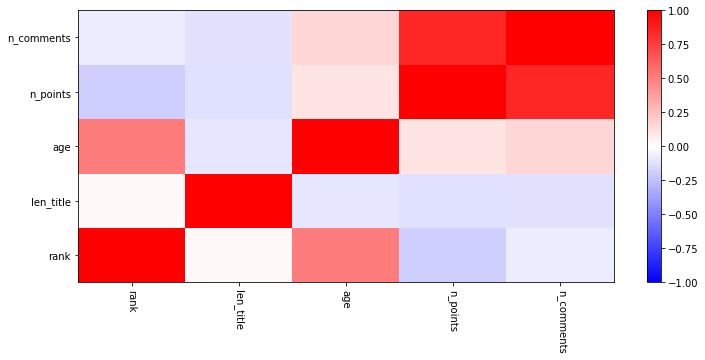

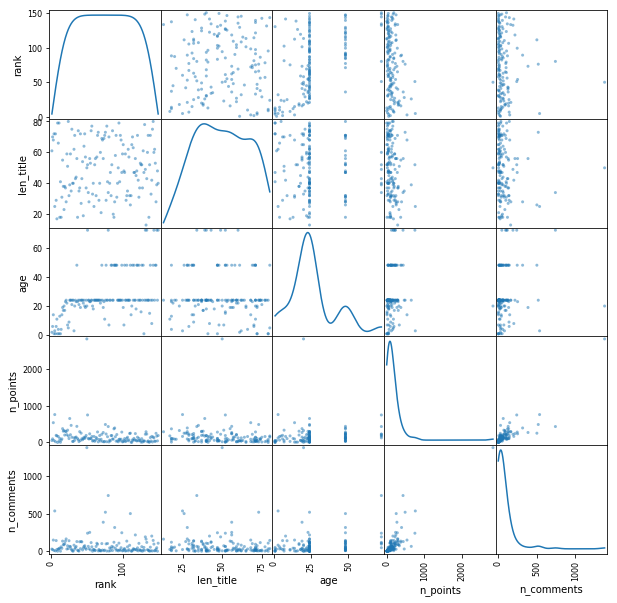

In [5]:
df = pd.read_csv("news_info.csv", sep=',')

%matplotlib inline

print(df.describe())
print()

# Correlation matrix heat map
plt.figure(figsize=(12, 5))
heatmap = plt.pcolor(df.corr(), cmap=plt.cm.bwr, vmin=-1, vmax=1)
labels = np.delete(df.columns.values, np.argwhere(df.columns.values == "PropType"))
plt.xticks(np.arange(0.5, 5, step=1), labels, rotation=270)
plt.yticks(np.arange(0.5, 5, step=1), labels)
plt.colorbar(heatmap);

# Scatterplot matrix of the correlations
pd.plotting.scatter_matrix(df, figsize=(10, 10), diagonal='kde');

In [9]:
reg = sm.ols(formula="rank ~ n_points", data=df).fit()
print("R-squared:", reg.rsquared)

reg = sm.ols(formula="rank ~ age", data=df).fit()
print("R-squared:", reg.rsquared)

reg = sm.ols(formula="rank ~ age + n_points + n_comments", data=df).fit()
print("R-squared:", reg.rsquared)

R-squared: 0.0367971176386
R-squared: 0.264674224657
R-squared: 0.333714104947


### Part 3 Classification

In [9]:
# Add front page (rank 30 or better) indicator variable
df['front_page'] = [1 if x <= 30 else 0 for x in df['rank']]

model = sm.logit(formula="front_page ~ n_comments + age", data=df).fit()
print(model.summary())
par = dict(model.params)

df['pred_pass'] = model.predict() > 0.5
pd.crosstab(index=df["front_page"], columns=df["pred_pass"])

Optimization terminated successfully.
         Current function value: 0.327269
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             front_page   No. Observations:                  150
Model:                          Logit   Df Residuals:                      147
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Jun 2018   Pseudo R-squ.:                  0.3460
Time:                        12:37:36   Log-Likelihood:                -49.090
converged:                       True   LL-Null:                       -75.060
                                        LLR p-value:                 5.265e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0658      0.660      3.130      0.002       0.772       3.359
n_comments     0.0003      0.

pred_pass,False,True
front_page,,
0,114,6
1,15,15
